# 🧠 Proximal Policy Optimization (PPO) for LunarLander-v3 — Modular Implementation

This Colab notebook implements a full training and evaluation pipeline for **OpenAI Gym's LunarLander-v3** environment using the **Proximal Policy Optimization (PPO)** algorithm. It includes:

- Modular architecture for easy extension and debugging
- Organized folder structure for saving models, plots, and videos
- Multi-episode video rendering


In [1]:
!pip install swig --quiet
!pip install gymnasium[box2d] box2d-py moviepy --quiet

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from datetime import datetime
from torch.distributions import Categorical
from gym.wrappers import RecordVideo

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/Lunar_lander_Project"

# Auto-increment run folder
existing_runs = [d for d in os.listdir(BASE_DIR) if d.startswith("run_")]
run_ids = [int(d.split("_")[1]) for d in existing_runs if d.split("_")[1].isdigit()]
run_number = max(run_ids, default=0) + 1
RUN_DIR = os.path.join(BASE_DIR, f"run_{run_number}")

# Create subfolders
WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
VIDEOS_DIR = os.path.join(RUN_DIR, "videos")
PLOTS_DIR = os.path.join(RUN_DIR, "plots")

os.makedirs(WEIGHTS_DIR, exist_ok=True)
os.makedirs(VIDEOS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"✅ Created new run folder: {RUN_DIR}")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Mounted at /content/drive
✅ Created new run folder: /content/drive/MyDrive/Lunar_lander_Project/run_4
Using device: cpu


## 🧠 ActorCritic Neural Network

This module defines the PPO actor-critic architecture. It consists of:
- **Actor Network**: Outputs a probability distribution over discrete actions using a softmax layer.
- **Critic Network**: Estimates the value of the current state to compute the advantage function.

Both networks are MLPs with two hidden layers of 64 units and ReLU activations.


In [2]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, action_dim), nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def act(self, state):
        state = state.to(device)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

    def evaluate(self, states, actions):
        states = states.to(device)
        actions = actions.to(device)
        probs = self.actor(states)
        dist = Categorical(probs)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        values = self.critic(states).squeeze()
        return logprobs, values, entropy


## 🔄 PPO Algorithm

This class implements the PPO algorithm with clipped surrogate objective and advantage estimation:
- Computes normalized advantages
- Performs multiple policy updates (`k_epochs`) per episode
- Optimizes a combined actor-critic loss

Hyperparameters such as `learning rate`, `gamma`, and `clip ratio` are configurable.


In [3]:
class PPO:
    def __init__(self, model, lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=4):
        self.model = model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.MseLoss = nn.MSELoss()

    def compute_returns(self, rewards, dones):
        returns = []
        R = 0
        for r, done in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - int(done))
            returns.insert(0, R)
        return torch.tensor(returns, dtype=torch.float32).to(device)

    def update(self, memory):
        states = torch.stack(memory.states).to(device)
        actions = torch.tensor(memory.actions).to(device)
        old_logprobs = torch.stack(memory.logprobs).detach().to(device)
        returns = self.compute_returns(memory.rewards, memory.dones)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)

        for _ in range(self.k_epochs):
            logprobs, state_values, entropy = self.model.evaluate(states, actions)
            ratios = torch.exp(logprobs - old_logprobs)
            advantages = returns - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2).mean() + 0.5 * self.MseLoss(state_values, returns) - 0.01 * entropy.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


## 📦 Experience Memory Buffer

This `Memory` class stores trajectories (state, action, log_prob, reward, done) during one episode. It is cleared after each PPO update.


In [4]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []

    def clear(self):
        self.__init__()


## 🎓 PPO Training Loop

This function:
- Interacts with the environment
- Collects trajectories using the current policy
- Updates the model every episode
- Saves model checkpoints every 50 episodes
- Logs per-episode reward
- Saves the final trained model and a reward curve

Model checkpoints and plots are saved in a structured folder like:

Lunar_lander_Project/
├── run_1
│   ├── weights
│   ├── plots


In [5]:
def train(env_name='LunarLander-v3', max_episodes=800, resume=False, checkpoint_path=None):
    # === Base directory ===
    BASE_DIR = "/content/drive/MyDrive/Lunar_lander_Project"

    # === Create new or resume run folder ===
    if resume:
        if not checkpoint_path:
            raise ValueError("To resume training, 'checkpoint_path' must be specified.")
        RUN_DIR = os.path.dirname(os.path.dirname(checkpoint_path))
        print(f"🔁 Resuming training from: {RUN_DIR}")
    else:
        existing_runs = [d for d in os.listdir(BASE_DIR) if d.startswith("run_")]
        run_ids = [int(d.split("_")[1]) for d in existing_runs if d.split("_")[1].isdigit()]
        run_number = max(run_ids, default=0) + 1
        RUN_DIR = os.path.join(BASE_DIR, f"run_{run_number}")
        os.makedirs(RUN_DIR, exist_ok=True)
        print(f"🚀 Starting new training run: {RUN_DIR}")

    # === Setup subdirectories ===
    WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
    PLOTS_DIR = os.path.join(RUN_DIR, "plots")
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

    # === Environment & PPO setup ===
    env = gym.make(env_name)
    memory = Memory()
    model = ActorCritic(env.observation_space.shape[0], env.action_space.n).to(device)

    if resume:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"✅ Loaded checkpoint from: {checkpoint_path}")

    ppo = PPO(model)
    ep_rewards = []

    # === Training loop ===
    for ep in range(1, max_episodes + 1):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        total_reward = 0

        while True:
            action, logprob, _ = model.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

            memory.states.append(state)
            memory.actions.append(torch.tensor(action).to(device))
            memory.logprobs.append(logprob)
            memory.rewards.append(reward)
            memory.dones.append(done)

            state = next_state
            total_reward += reward

            if done:
                break

        ppo.update(memory)
        memory.clear()
        ep_rewards.append(total_reward)

        print(f"Episode {ep}, Reward: {total_reward:.2f}")

        # Save checkpoint with timestamp
        if ep % 50 == 0:
          timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
          checkpoint_name = f"ppo_checkpoint_{timestamp}.pt"
          torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, checkpoint_name))


    # === Save final model ===
    torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "ppo_final.pt"))

    # === Plot and save reward graph ===
    plt.figure(figsize=(10, 5))
    plt.plot(ep_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("PPO Training Reward")
    plt.grid()
    plt.savefig(os.path.join(PLOTS_DIR, "training_reward_plot.png"))
    plt.show()

    print(f"✅ Training complete. Final model and results saved under: {RUN_DIR}")



## evaluate.py — Evaluation

In [6]:
def evaluate(model_path=None, render_random=False, max_steps=1000, episodes=5):
    BASE_DIR = "/content/drive/MyDrive/Lunar_lander_Project"

    # Determine RUN_DIR
    if model_path:
        WEIGHTS_DIR = os.path.dirname(model_path)
        RUN_DIR = os.path.dirname(WEIGHTS_DIR)
    else:
        existing_runs = [d for d in os.listdir(BASE_DIR) if d.startswith("run_")]
        if not existing_runs:
            raise FileNotFoundError("No runs found under Lunar_lander_Project.")
        run_ids = [int(d.split("_")[1]) for d in existing_runs if d.split("_")[1].isdigit()]
        latest_run = f"run_{max(run_ids)}"
        RUN_DIR = os.path.join(BASE_DIR, latest_run)
        model_path = os.path.join(RUN_DIR, "weights", "ppo_final.pt")

    # Setup video directory
    VIDEOS_DIR = os.path.join(RUN_DIR, "videos")
    os.makedirs(VIDEOS_DIR, exist_ok=True)
    timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
    label = "random" if render_random else "trained"
    video_subdir = f"eval_{label}_{timestamp}"
    video_folder = os.path.join(VIDEOS_DIR, video_subdir)

    # Create environment for multi-episode video
    env = gym.make('LunarLander-v3', render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

    # Load model
    model = ActorCritic(env.observation_space.shape[0], env.action_space.n).to(device)
    if not render_random:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"✅ Loaded model from: {model_path}")
    model.eval()

    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        total_reward = 0

        for _ in range(max_steps):
            if render_random:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action, _, _ = model.act(state)

            next_state, reward, done, _ = env.step(action)
            state = torch.tensor(next_state, dtype=torch.float32).to(device)
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"🎮 Episode {ep + 1} — Reward: {total_reward:.2f}")

    env.close()
    print(f"🎬 Saved {episodes} episodes in one video to: {video_folder}")
    return total_rewards

## Run Training

🔁 Resuming training from: /content/drive/MyDrive/Lunar_lander_Project/run_3


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


✅ Loaded checkpoint from: /content/drive/MyDrive/Lunar_lander_Project/run_3/weights/ppo_checkpoint_29052025_110950.pt
Episode 1, Reward: 143.24
Episode 2, Reward: 66.82
Episode 3, Reward: 163.65
Episode 4, Reward: 177.02
Episode 5, Reward: 134.42
Episode 6, Reward: 253.43
Episode 7, Reward: 120.68
Episode 8, Reward: 154.81
Episode 9, Reward: 155.69
Episode 10, Reward: 137.22
Episode 11, Reward: 177.76
Episode 12, Reward: 111.13
Episode 13, Reward: 187.57
Episode 14, Reward: 153.95
Episode 15, Reward: 137.63
Episode 16, Reward: 158.76
Episode 17, Reward: 154.41
Episode 18, Reward: 260.82
Episode 19, Reward: 130.08
Episode 20, Reward: 155.31
Episode 21, Reward: 124.01
Episode 22, Reward: 139.80
Episode 23, Reward: 148.20
Episode 24, Reward: 128.81
Episode 25, Reward: 168.53
Episode 26, Reward: 144.36
Episode 27, Reward: 176.83
Episode 28, Reward: 153.70
Episode 29, Reward: 182.21
Episode 30, Reward: 146.06
Episode 31, Reward: 141.47
Episode 32, Reward: 158.03
Episode 33, Reward: 158.32
E

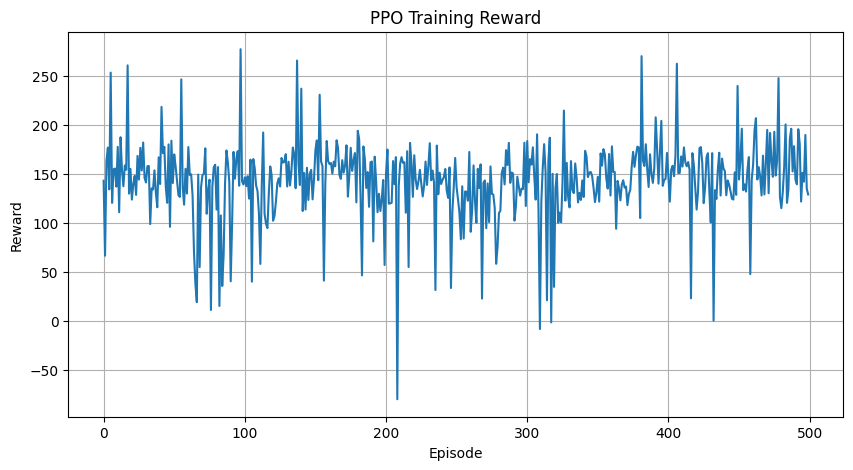

✅ Training complete. Final model and results saved under: /content/drive/MyDrive/Lunar_lander_Project/run_3


In [7]:
#train(env_name='LunarLander-v3', max_episodes=5000, resume=False)

#train(max_episodes=800, resume=True)
train(max_episodes=500, resume=True, checkpoint_path="/content/drive/MyDrive/Lunar_lander_Project/run_3/weights/ppo_checkpoint_29052025_110950.pt")



## Run Evaluation (Trained Agent)

In [8]:
# Evaluate trained model with 5 episodes in one video
#evaluate(episodes=5)

# Evaluate a specific checkpoint
evaluate(model_path="/content/drive/MyDrive/Lunar_lander_Project/run_3/weights/ppo_final.pt", episodes=3)

# Evaluate random agent
evaluate(render_random=True, episodes=2)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


✅ Loaded model from: /content/drive/MyDrive/Lunar_lander_Project/run_3/weights/ppo_final.pt
🎮 Episode 1 — Reward: 134.52
🎮 Episode 2 — Reward: 156.01
🎮 Episode 3 — Reward: 8.44
🎬 Saved 3 episodes in one video to: /content/drive/MyDrive/Lunar_lander_Project/run_3/videos/eval_trained_29052025_150245


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


🎮 Episode 1 — Reward: -94.78
🎮 Episode 2 — Reward: -70.36
🎬 Saved 2 episodes in one video to: /content/drive/MyDrive/Lunar_lander_Project/run_4/videos/eval_random_29052025_150313


[np.float64(-94.78365204563572), np.float64(-70.35897025715035)]